<center><img src="img/logo_hse.png" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 1: Генеративные сети</center></h2>

# Введение

Не все же нам MNIST генерировать. Давайте посмотрим, как генеративные модели могут использоваться не только для развлечения. Поехали!

Немного вступления и мотивации, для чего мы хотим обучать модель.

## MAGIC – Major Atmospheric Gamma Imaging Cherenkov Telescope

MAGIC (Major Atmospheric Gamma Imaging Cherenkov) - это система, состоящая из двух черенковских телескопов диаметром 17 м. Они предназначены для наблюдения гамма-лучей от галактических и внегалактических источников в диапазоне очень высоких энергий (от 30 ГэВ до 100 ТэВ).

MAGIC позволил открыть и исследовать новые классы источников гамма-излучения, таких как, например, пульсары и гамма-всплески (GRB).

<center><img src="img/magic1.jpg" width="1000"></center>

Источник: https://magic.mpp.mpg.de/

Youtube video: https://youtu.be/mjcDSR2vSU8

#### Ок, давайте зафиксируем. Какой-то крутой телескоп позволяет открыть новые виды излучения. Идем дальше.

## Частицы из космоса

Космические частицы, $\gamma$-кванты (фотоны) и адроны (протоны), взаимодействуют с атмосферой и порождают ливни вторичных частиц. Двигаясь с околосветовой скоростью, эти частицы излучают Черенковское излучение. Телескопы фотографируют это излучение.
#### По фотографиям можно определить тип частицы из космоса: фотон или протон. Знакомая формулировка задачи, не правда ли?

<center><img src="img/shower.jpg" width="500"></center>

## Фотографии

Задача атмосферного черенковского телескопа - получить изображение ливня путем измерения черенковского света от частиц ливня. Это изображение представляет собой геометрическую проекцию ливня на детектор. Для анализа этих изображений были введены параметры изображения или так называемые параметры Хилласа. Ниже пример такой фотографии.

<center><img src="img/geo.jpg" width="400"></center>

#### Итак, каждая фотография описывается набором параметров, которые за нас считает телесоп. А что там с двумя видами частиц?

## Фотоны vs адронов

Изображения для $\gamma$-квантов (фотонов) и адронов (протонов) отличаются по форме кластеров. Астрономы используют модели машинного обучения для классификации этих изображений. Получение каждого такого изображения - дорогое удовольствие!


<center><img src="img/gamma_p.png" width="600"></center>

Для обучения моделей ученые искусственно генерируют такие изображения для каждого типа частиц с помощью сложных физических симуляторов.

#### Итак, давайте сэкономим денег для ученых и сгенерируем хороших фотографий разных частиц. Используем для этого GAN и диффузионные модели!

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Данные

Будем использовать данные телескопа MAGIC из UCI репозитория https://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope. Каждый объект в данных - параметры одного изображения кластера и метка этого кластера (фотон или адрон):


0. Length: major axis of ellipse [mm]
1. Width: minor axis of ellipse [mm]
2. Size: 10-log of sum of content of all pixels [in #phot]
3. Conc: ratio of sum of two highest pixels over fSize [ratio]
4. Conc1: ratio of highest pixel over fSize [ratio]
5. Asym: distance from highest pixel to center, projected onto major axis [mm]
6. M3Long: 3rd root of third moment along major axis [mm]
7. M3Trans: 3rd root of third moment along minor axis [mm]
8. Alpha: angle of major axis with vector to origin [deg]
9. Dist: distance from origin to center of ellipse [mm]
10. class: g,h # gamma (signal), hadron (background)

In [2]:
# read data
names = np.array(
    [
        "Length",
        "Width",
        "Size",
        "Conc",
        "Conc1",
        "Asym",
        "M3Long",
        "M3Trans",
        "Alpha",
        "Dist",
        "class",
    ]
)
data = pd.read_csv("magic04.data.csv", header=None)
data.columns = names
print(data.shape)
data.head()

(19020, 11)


,Length,Width,Size,Conc,Conc1,Asym,M3Long,M3Trans,Alpha,Dist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


# Постановка задачи

Ваша задача заключается в том, чтобы с помощью генеративно-состязательных сетей научиться генерировать параметры кластеров на изображениях телескопа для каждого типа частиц (фотона или адрона):

- $X$ - матрица реальных объектов, которые нужно начиться генерировать;
- $y$ - метки классов, которые будем использовать как условие при генерации.

In [3]:
# параметры кластеров на изображениях
X = data[names[:-1]].values
X = np.abs(X)

# метки классов
labels = data[names[-1]].values
y = np.ones((len(labels), 1))
y[labels == "h"] = 0

In [4]:
# примеры
X[:2]

array([[2.87967e+01, 1.60021e+01, 2.64490e+00, 3.91800e-01, 1.98200e-01,
        2.77004e+01, 2.20110e+01, 8.20270e+00, 4.00920e+01, 8.18828e+01],
       [3.16036e+01, 1.17235e+01, 2.51850e+00, 5.30300e-01, 3.77300e-01,
        2.62722e+01, 2.38238e+01, 9.95740e+00, 6.36090e+00, 2.05261e+02]])

In [5]:
# примеры
y[:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [6]:
# все возможные значения
np.unique(y)

array([0., 1.])

# Визуализация данных

Каждое изображение описывается 10 параметрами. Давайте построим распределения значений каждого параметра для каждого типа частиц.

In [7]:
def plot_hists(X1, X2, names, label1, label2, bins=np.linspace(-3, 3, 61)):
    plt.figure(figsize=(5 * 4, 5 * 2))
    for i in range(X1.shape[1]):
        plt.subplot(3, 4, i + 1)
        plt.grid()
        plt.hist(X1[:, i], bins=bins, alpha=0.3, label=label1, color="C4")
        plt.hist(X2[:, i], bins=bins, alpha=0.3, label=label2, color="C0")
        plt.xlabel(names[i], size=14)
        plt.legend(loc="best")
    plt.tight_layout()

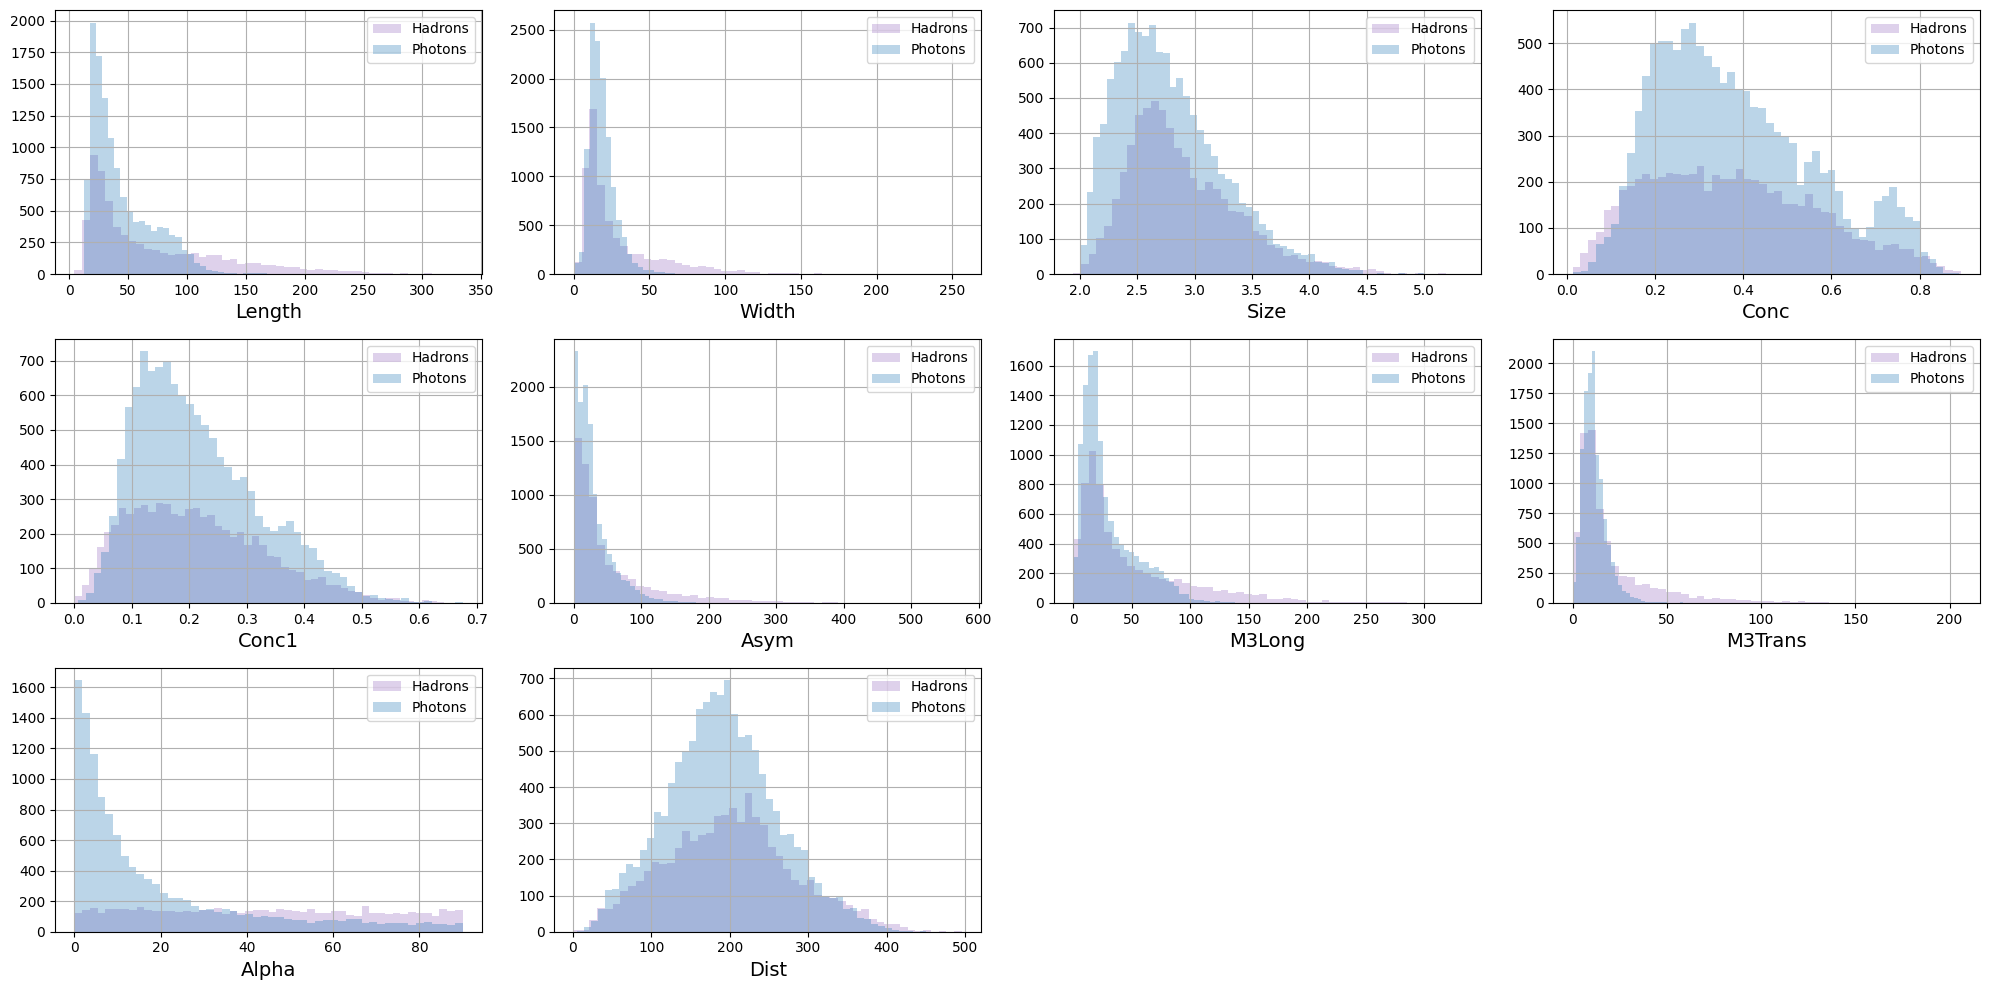

In [8]:
plot_hists(
    X[y[:, 0] == 0], X[y[:, 0] == 1], names, label1="Hadrons", label2="Photons", bins=50
)

# Предобработка данных

Из графика видим, что распределения для многих признаков имеют тяжелые хвосты. Это делает обучение генеративных моделей тяжелее. Поэтому нужно как-то преобразовать данные, чтобы убрать эти тяжелые хвосты.

# Обучающая и тестовая выборки

In [9]:
from sklearn.model_selection import train_test_split

# train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.5, shuffle=True, random_state=11
)

## Задание 1 (0.2 балла)

Проиллюстрируйте распределение y внутри train и test выборки.

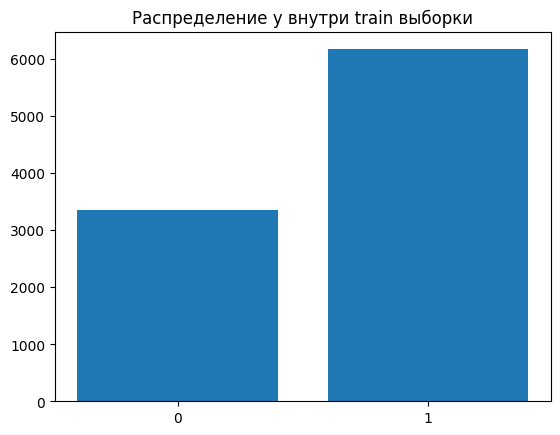

In [10]:
y_0_train = len([x for x in y_train if x == 0]) # Количество объектов 0 кластера
y_1_train = len([x for x in y_train if x == 1]) # Количество объектов 1 кластера
plt.bar(['0', '1'], [y_0_train, y_1_train])
plt.title('Распределение y внутри train выборки')
plt.show()

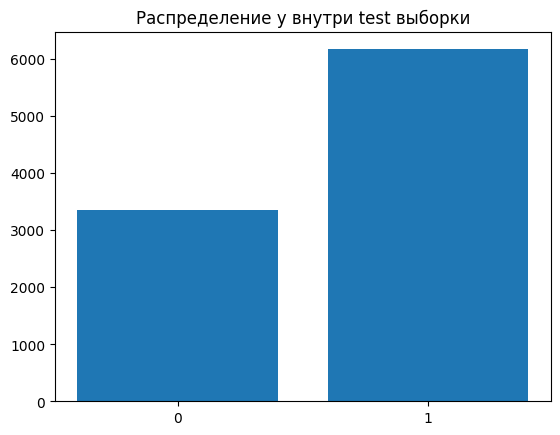

In [11]:
y_0_test = len([x for x in y_test if x == 0]) # Количество объектов 0 кластера
y_1_test = len([x for x in y_test if x == 1]) # Количество объектов 1 кластера
plt.bar(['0', '1'], [y_0_test, y_1_test])
plt.title('Распределение y внутри test выборки')
plt.show()

## Задание 2 (0.8 балл)

Используя функцию `sklearn.preprocessing.QuantileTransformer` трансформируйте входные данные `X_train` и `X_test`. Это преобразование делает так, чтобы распределение каждого параметра было нормальным. Описание функции доступно по [ссылке](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html). Используйте значение параметра `output_distribution='normal'`.

In [12]:
### YOUR CODE IS HERE ######
from sklearn.preprocessing import QuantileTransformer
transformer = QuantileTransformer(output_distribution = 'normal') #Берем нормальное распределение
X_train = transformer.fit_transform(X_train) #Обучаем и трансформируем тренировочную выборку
X_test = transformer.transform(X_test) #Тестовую просто трансформируем без обучения
### THE END OF YOUR CODE ###

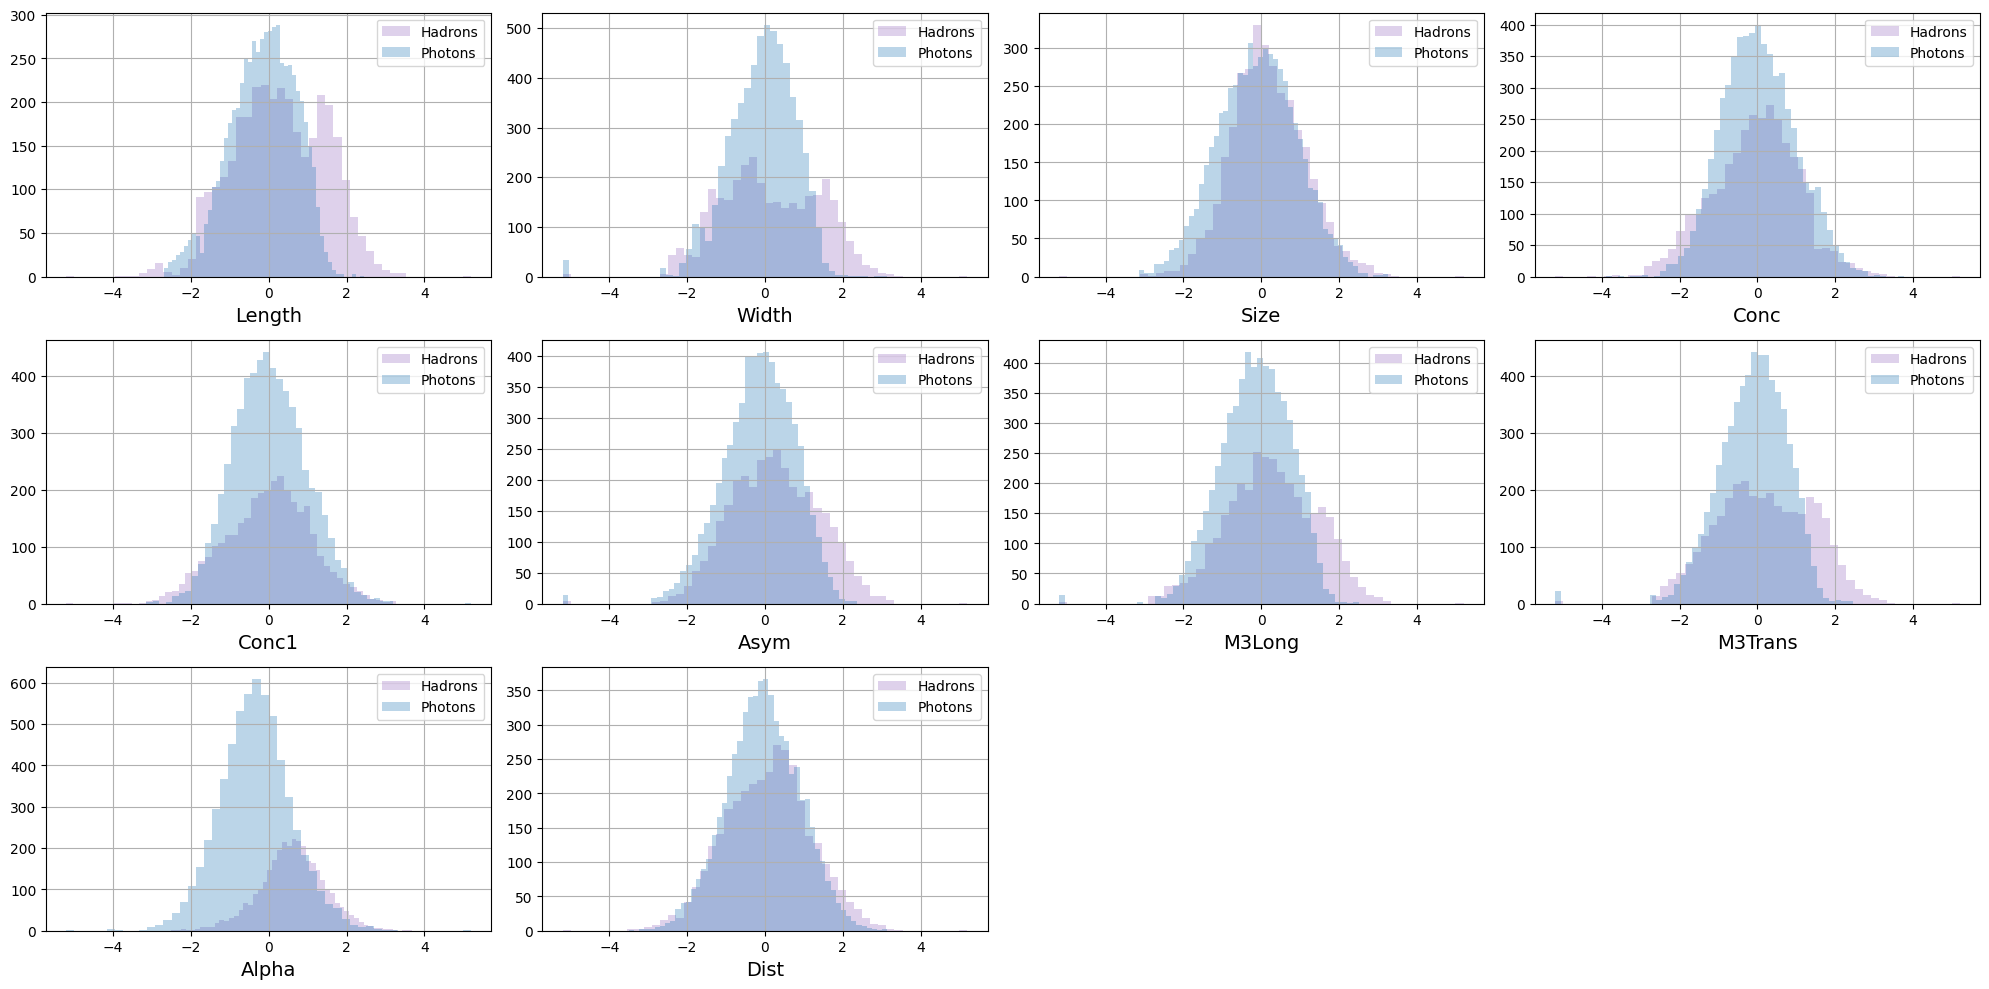

In [13]:
plot_hists(
    X_train[y_train[:, 0] == 0],
    X_train[y_train[:, 0] == 1],
    names,
    label1="Hadrons",
    label2="Photons",
    bins=50,
)

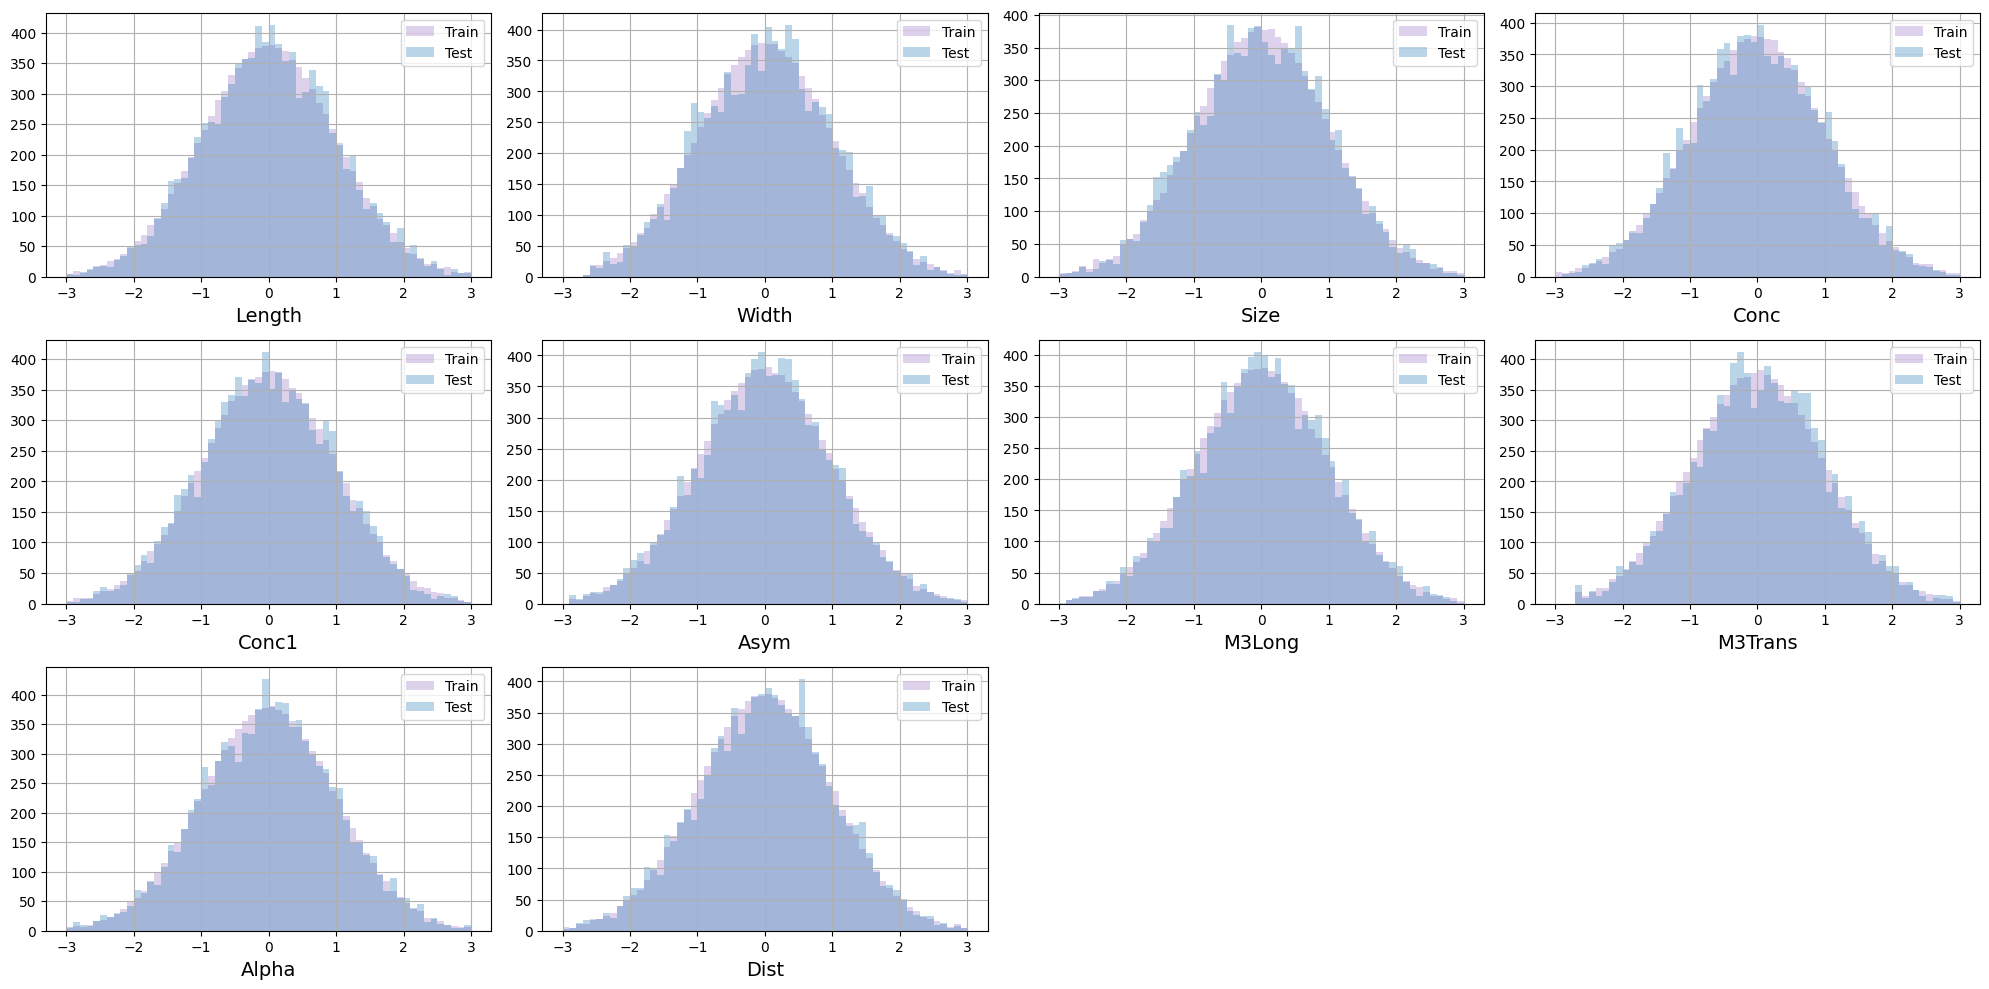

In [14]:
plot_hists(X_train, X_test, names, label1="Train", label2="Test")

# Conditional WGAN

Мы будем использовать `Conditional WGAN`, который изображен на рисунке. В качестве условия `y` мы будем использовать метку класса: **0** - адрон, **1** - фотон. Таким образом, мы будем сообщать генератору для какой частицы нужно генерировать параметры изображения.

<center><img src="img/cgan.png" width="800"></center>

Генератор $\hat{x} = G(z, y)$ будет принимать на вход шумовой вектор $z$ и вектор условий $y$, а выдавать будет сгенерированный (фейковый) вектор параметров $\hat{x}$.

Дискриминатор $D(x, y)$ будет принимать на вход вектор параметров $x$ и вектор условий $y$, а возвращать будет рациональное число.

Обучать `Conditional WGAN` будем с такой функцией потерь:

$$L(G, D) = -\frac{1}{n} \sum_{x_i \in X, y_i \in y} D(x_i, y_i) + -\frac{1}{n} \sum_{z_i \in Z, y_i \in y} D(G(z_i, y_i), y_i) \to \max_G \min_D$$

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
DEVICE

device(type='cuda')

## Задание 3 (0.75 балла)

Реализуйте нейронную сеть для генератора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [17]:
class Generator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(Generator, self).__init__()

        ### YOUR CODE IS HERE ######
        self.fc1 = nn.Linear(n_inputs, 100) #Полносвязный слой со 100 нейронами
        self.bn1 = nn.BatchNorm1d(100) # Слой батч-нормализации
        self.relu1 = nn.ReLU() # ReLU функцию активации
        self.fc2 = nn.Linear(100, 100) # Полносвязный слой со 100 нейронами
        self.bn2 = nn.BatchNorm1d(100) # Слой батч-нормализации
        self.relu2 = nn.ReLU() # ReLU функцию активации
        self.fc3 = nn.Linear(100, n_outputs) # Выходной слой
        ### THE END OF YOUR CODE ###

    def forward(self, z, y):
        zy = torch.cat((z.cuda(), y.cuda()), dim=1) #Тут добавила .cuda() чтоб перевести на эту среду выполнения, иначе оно ломается
        output = self.fc1(zy) #Применяем все слои и функции по очереди
        output = self.bn1(output)
        output = self.relu1(output)
        output = self.fc2(output)
        output = self.bn2(output)
        output = self.relu2(output)
        output = self.fc3(output)
        return output

## Задание 4 (0.5 балл)

Реализуйте функцию для генерации новый объектов $X$ по вектору условий $y$.

In [18]:
def generate(generator, y, latent_dim):
    ### YOUR CODE IS HERE ######
    #На лекции мы брали нормальное распределение для генерации, поэтому тут сделаю так же
    z = torch.normal(0, 1, (len(y), latent_dim)) #Генерируем выборку из нормального распределения с 0 средним и 1 отклонением, размерность берем как у и latent_dim
    y = torch.tensor(y).float() #Переводим в float, без этого не работает
    with torch.no_grad(): #Отключаем градиенты
      X_fake = generator(z.cuda(), y.cuda()).detach().cpu().numpy()  #Создаем новые объекты с помощью генератора по шуму и у
    ### THE END OF YOUR CODE ###
    return X_fake  # numpy - перевела в нампай выше

## Задание 5 (0.75 балла)

Реализуйте нейронную сеть для дискриминатора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Выходной слой.

Какая функция активации должна быть в конце работы модели и почему? А она вообще тут должна быть? Обоснуйте свой выбор.

В конце ставлю сигмоиду, чтобы перевести числа в вероятности для задачи бинарной классификации

In [19]:
class Discriminator(nn.Module):
    def __init__(self, n_inputs):
        super(Discriminator, self).__init__()

        ### YOUR CODE IS HERE ######
        self.fc1 = nn.Linear(n_inputs, 100) #Полносвязный слой со 100 нейронами
        self.relu1 = nn.ReLU() # ReLU функцию активации
        self.fc2 = nn.Linear(100, 100) # Полносвязный слой со 100 нейронами
        self.relu2 = nn.ReLU() # ReLU функцию активации
        self.fc3 = nn.Linear(100, 1) # Выходной слой
        self.sigm = nn.Sigmoid() #Сигмоида в конце, по идее она должна быть, тк у нас задача бинарной классификации тут и нам нужны вероятности
        # (те мы переводим числа в промежток от 0 до 1). + в семинаре мы тоже в дискриминаторе использовали сигмоиду для двумерных данных
        ### THE END OF YOUR CODE ###

    def forward(self, x, y):
        xy = torch.cat((x.cuda(), y.cuda()), dim=1) #Тут добавила .cuda() чтоб перевести на эту среду выполнения, иначе оно ломается
        output = self.fc1(xy) #Применяем все слои и функции по очереди
        output = self.relu1(output)
        output = self.fc2(output)
        output = self.relu2(output)
        output = self.fc3(output)
        output = self.sigm(output)

        return output

## Задание 6 (0.5 балла)

Реализуйте функцию, которая принимала бы на вход набор сгенерированных и настоящих объектов, разбивала на train и test с учетом баланса классов (real и fake объектов), с соотношением 3 к 1, обучала модель логистической регрессии и градиентного бустинга, которые учились бы отличать настоящие объекты от фальшивых, после чего выводила бы accuracy score на отложенной выборке у обоих моделей.

Ответьте на вопрос: какое значение accuracy score нас бы удовлетворило больше всего? Почему?

Наверное чем ниже, тем лучше. Мы хотим, чтобы наша модель генерировала объекты настолько хорошо, что их сложно было бы отличать от настоящих (поэтому мы хотим тут качество как можно меньше, чтобы дискриминатору было сложно отличить фейки от реальных объектов)

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
def other_agent_score(X_real, y_real, X_fake, y_fake):
    ### YOUR CODE IS HERE ######
    X = np.concatenate((X_real, X_fake), axis=0) # Соединяем все в один вектор
    y = np.concatenate((y_real, y_fake), axis=0)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y) #баланс классов учитываем по у, соотношение 3:1 => процент теста 25%, те 1/4

    lin_reg = LogisticRegression() # Логистическая регрессия
    lin_reg.fit(X_train, y_train) #Обучаем ее на трейне
    y_pred_lin_reg = lin_reg.predict(X_test) #Делаем предсказания
    lin_reg_score = accuracy_score(y_test, y_pred_lin_reg) #Акураси на тесте

    boost = GradientBoostingClassifier() #Градиентный бустинг
    boost.fit(X_train, y_train) #Обучаем
    y_pred_boost = boost.predict(X_test) #Делаем предсказания
    boosting_score = accuracy_score(y_test, y_pred_boost)#Акураси на тесте
    ### THE END OF YOUR CODE ###
    print("Linear regression score: " + str(lin_reg_score))
    print("Boosting score: " + str(boosting_score))

## Задание 7 (1.5 балла)

Реализуйте класс для обучения генеративной модели.

- Уточнение 1: Нужно ограничивать веса дискриминатора. Для этого используйте `p.data.clamp_(-0.01, 0.01)`, где `p` веса дискриминатора. Зачем это делать можно посмотреть в оригинальной статье <https://arxiv.org/pdf/1701.07875.pdf>.
- Подсказка 1: `n_critic` - число итераций обучения дискриминатора на одну итерацию обучения генератора.
- Подсказка 2: Используйте `X_tensor = torch.tensor(X_numpy, dtype=torch.float, device=DEVICE)` для перевода numpy в тензор.

In [21]:
class Fitter(object):
    def __init__(
        self,
        generator,
        discriminator,
        batch_size=32,
        n_epochs=10,
        latent_dim=1,
        lr=0.0001,
        n_critic=5,
    ):

        self.generator = generator
        self.discriminator = discriminator
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.opt_gen = torch.optim.RMSprop(self.generator.parameters(), lr=self.lr)
        self.opt_disc = torch.optim.RMSprop(self.discriminator.parameters(), lr=self.lr)

        self.generator.to(DEVICE)
        self.discriminator.to(DEVICE)

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.generator.train(True)
        self.discriminator.train(True)

        self.loss_history = []
        self.gen_loss_trace = [] #Это я добавила списки лоссов для генератора и дискриминатора отдельно (по логике из семинара)
        self.discr_loss_trace = []

        # Fit GAN
        for epoch in range(self.n_epochs):
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):

                ### YOUR CODE IS HERE ######
                ##Я тут делаю этапы обучения по последовательности из семинара
                num_objects = real_batch.shape[0] #Количество объектов
                z = torch.normal(0, 1, (num_objects, self.latent_dim)) #Создаем шум из нормального распределения
                gen_objects = self.generator(z, cond_batch) #Генератор

                if i % (self.n_critic+1) == 0: #Мы берем здесь n+1, тк у нас 5 итераций обучения дискриминатора на 1 итерацию генератора -> всего генератор обучается 1/6 из 6 итераций
                #Это обучение генератора
                  self.opt_gen.zero_grad() #Обнуляем градиенты
                  gen_loss = - torch.mean(self.discriminator(gen_objects, cond_batch)) #Лосс
                  gen_loss.backward()
                  self.opt_gen.step() #Шаг оптимизатора
                  self.gen_loss_trace.append((i, gen_loss.item())) #Это было в семинаре, просто отдельные лоссы считаем, оставлю на всякий случай
                else: #Это обучение дискриминатора (5 итераций подряд будет идти)
                  self.opt_disc.zero_grad() #Обнуляем градиенты
                  discr_loss = - torch.mean(self.discriminator(real_batch, cond_batch)) + torch.mean(self.discriminator(gen_objects.detach(), cond_batch)) #Лосс
                  discr_loss.backward()
                  for p in self.discriminator.parameters():
                        p.data.clamp_(-0.01, 0.01) #Ставим ограничения на параметры
                  self.opt_disc.step() #Шаг оптимизатора
                  self.discr_loss_trace.append((i, discr_loss.item())) #Тоже в семинаре добавляли лосс отдельно, оставлю
                ### THE END OF YOUR CODE ###

            # caiculate and store loss after an epoch
            Z_noise = torch.normal(0, 1, (len(X_real), self.latent_dim))
            X_fake = self.generator(Z_noise, y_cond)
            loss_epoch = torch.mean(self.discriminator(X_real, y_cond)) - torch.mean(
                self.discriminator(X_fake, y_cond)
            )
            self.loss_history.append(loss_epoch.detach().cpu())

            # Создайте выборку из 1000 объектов из X_train и 1000 сгенерированных объектов
            # И запустите работу фукнции other_agent_score

            ### YOUR CODE IS HERE ######
            real_ob = X_real[:1000].to(DEVICE) #Реальные объекты
            z2 = torch.normal(0, 1, (1000, self.latent_dim)) #Шум
            fake_ob = self.generator(z2, y_cond[:1000]) #Фейковые сгенерированные объекты
            other_agent_score(real_ob.cpu().detach().numpy(), torch.ones(1000), fake_ob.cpu().detach().numpy(), torch.zeros(1000)) #Запускаем функцию
            ### THE END OF YOUR CODE ###

        # Turn off training
        self.generator.train(False)
        self.discriminator.train(False)

## Обучение
Обучим модель на данных.

In [22]:
%%time
latent_dim = 10
generator = Generator(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1])
discriminator = Discriminator(n_inputs=X_train.shape[1] + y.shape[1])

fitter = Fitter(
    generator,
    discriminator,
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
fitter.fit(X_train, y_train)

Linear regression score: 0.772
Boosting score: 0.966
Linear regression score: 0.638
Boosting score: 0.918
Linear regression score: 0.592
Boosting score: 0.914
Linear regression score: 0.552
Boosting score: 0.92
Linear regression score: 0.484
Boosting score: 0.92
Linear regression score: 0.532
Boosting score: 0.904
Linear regression score: 0.602
Boosting score: 0.886
Linear regression score: 0.532
Boosting score: 0.84
Linear regression score: 0.526
Boosting score: 0.836
Linear regression score: 0.532
Boosting score: 0.828
Linear regression score: 0.522
Boosting score: 0.812
Linear regression score: 0.508
Boosting score: 0.772
Linear regression score: 0.496
Boosting score: 0.75
Linear regression score: 0.488
Boosting score: 0.712
Linear regression score: 0.524
Boosting score: 0.718
Linear regression score: 0.476
Boosting score: 0.696
Linear regression score: 0.54
Boosting score: 0.7
Linear regression score: 0.5
Boosting score: 0.686
Linear regression score: 0.518
Boosting score: 0.682
Li

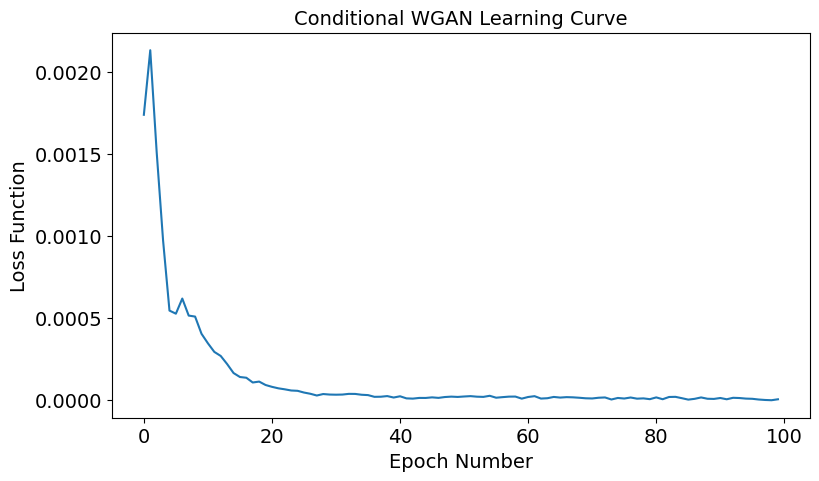

In [23]:
# WGAN learning curve
plt.figure(figsize=(9, 5))
plt.plot(fitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional WGAN Learning Curve", size=14)
# plt.grid(b=1, linestyle="--", linewidth=0.5, color="0.5") - это почему-то дает ошибку ValueError, поэтому убрала его
plt.show()

## Задание 8 (0.5 балла)

Теперь сгенерируем фейковые матрицы `X_fake_train` и `X_fake_test`. Сравним их с матрицами реальных объектов `X_train` и `X_test`. Перед сравнением результатов сделайте обратное квантильное преобразование с помощью трансформера, который вы обучили в задании 2.

In [24]:
### YOUR CODE IS HERE ######
X_fake_train = generate(fitter.generator, y_train, latent_dim)
X_fake_train_tr = transformer.inverse_transform(X_fake_train) #Обратное преобразование
X_train_tr = transformer.inverse_transform(X_train)
### THE END OF YOUR CODE ###

In [25]:
# X_fake_train = generate(fitter.generator, y_train, latent_dim)

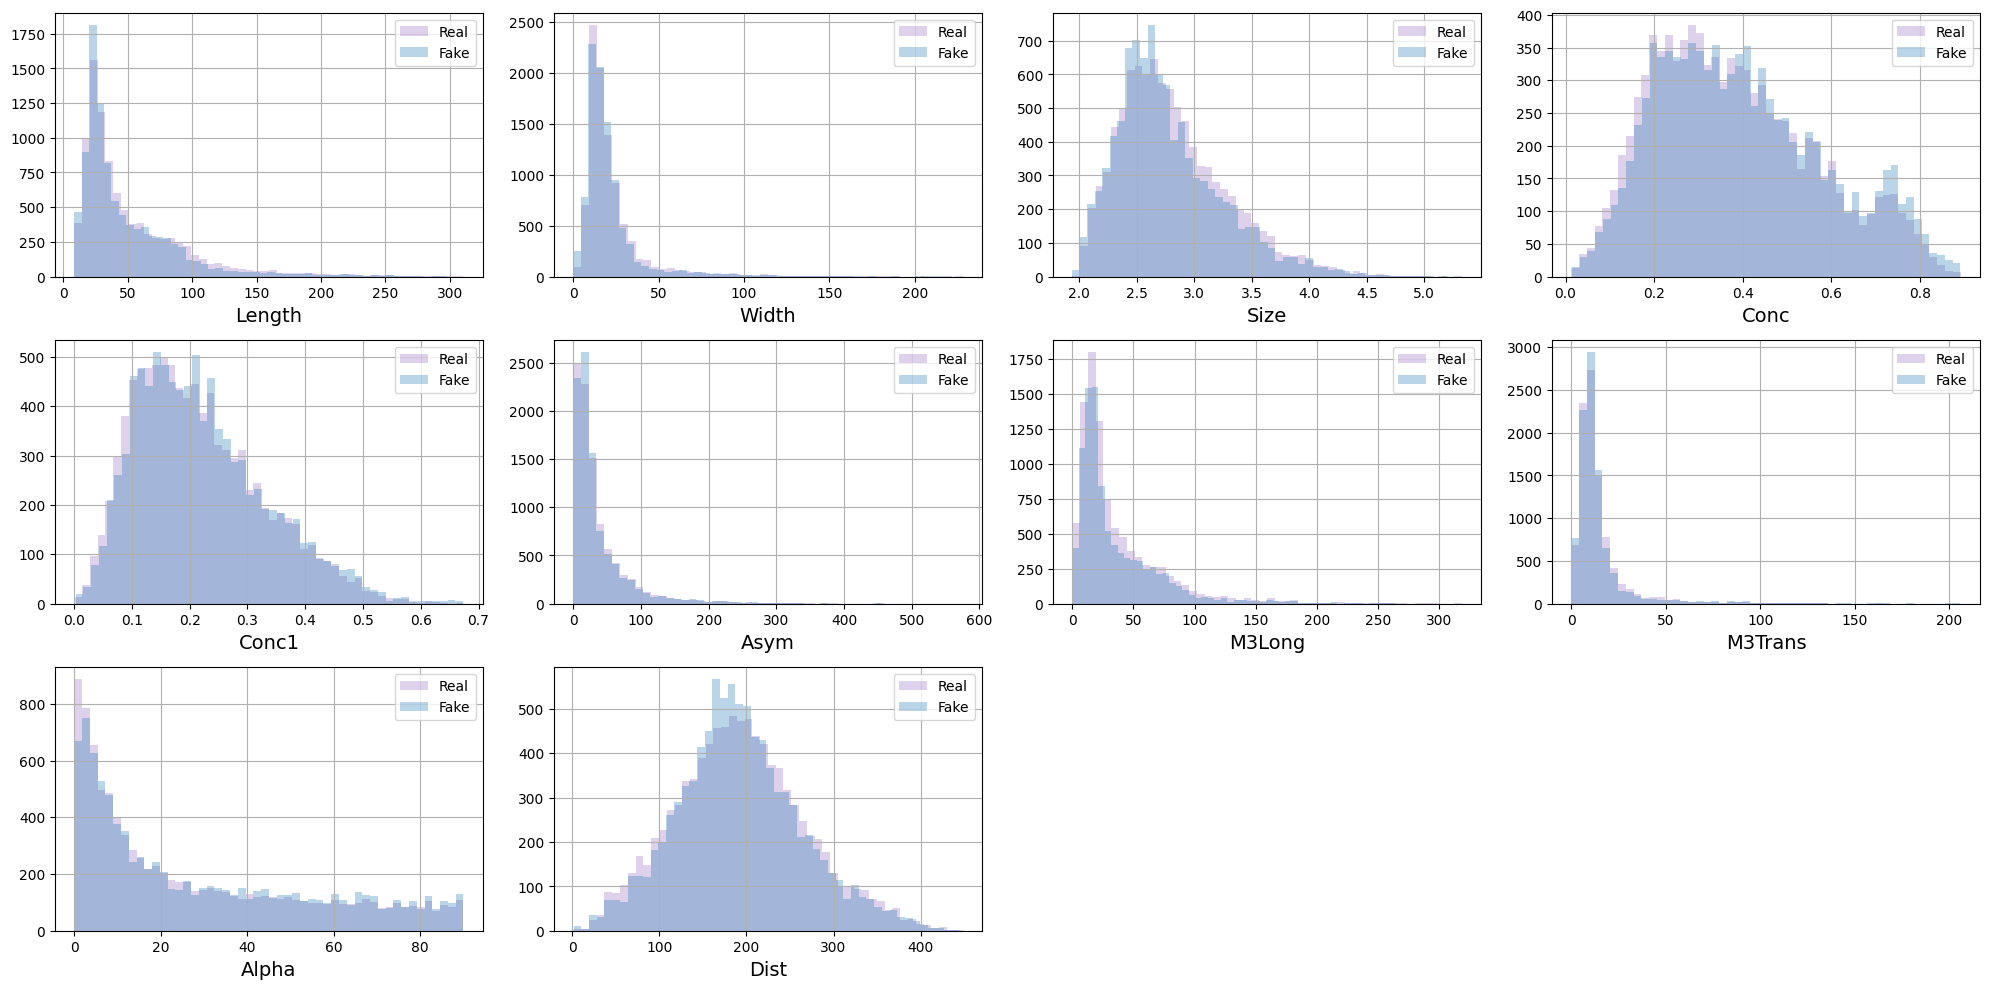

In [26]:
plot_hists(X_train_tr, X_fake_train_tr, names, label1="Real", label2="Fake", bins=50)

In [27]:
X_fake_test = generate(fitter.generator, y_test, latent_dim)
X_fake_test_tr = transformer.inverse_transform(X_fake_test) #Обратное преобразование
X_test_tr=transformer.inverse_transform(X_test)

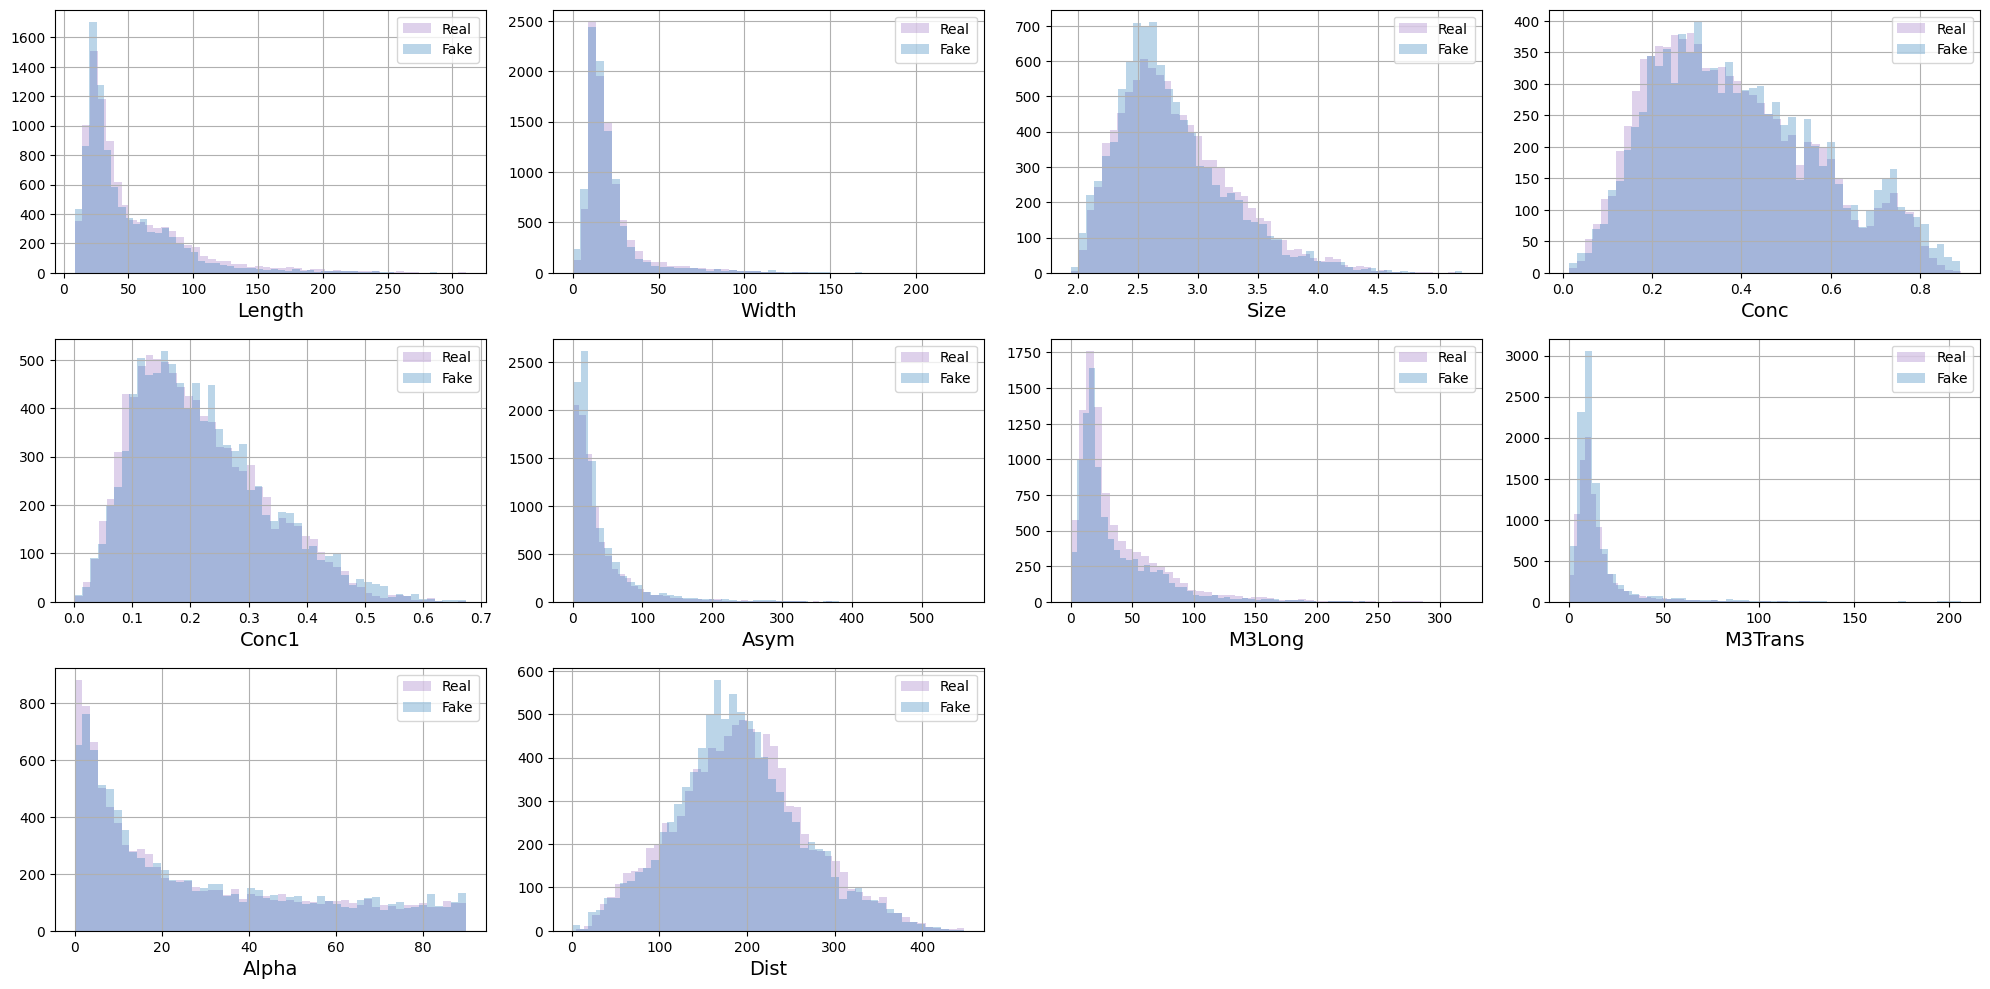

In [28]:
plot_hists(X_test_tr, X_fake_test_tr, names, label1="Real", label2="Fake", bins=50)

## Вывод:
Визуально мы видим сходство реальных и фейковых данных. Однако это только проекции 10-мерных объектов на одну ось.

# Измерение качества генерации

<center><img src="img/clf.png" width="600"></center>

Измерим сходство распределений классификатором.

In [29]:
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train, X_train), axis=0)
XX_test = np.concatenate((X_fake_test, X_test), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test))

In [30]:
from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [31]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.7073192919954755


## Задание 9 (0.5 балла)

Опишите ваш эксперимент. Как вы оцениваете полученные результаты? Как вы думаете, какое значение ROC AUC нас удовлетворяет больше всего? Почему?


Здесь мы смотрели на то, сможет ли классификатор отличать фейковые объекты от реальных. У нас получился средний ROC AUC, то есть хороший результат - классификатор способен отличать фейковые объекты от реальных, но он все-таки иногда путается и не идеально их различает. Думаю, что нас удовлетворяет среднее возможное значение ROC AUC. Чем ближе к середине, чем лучше (можно предположить, что 0.5 будет нормально), тк мы хотим добиться ситуации, когда наши фековые объекты очень сильно похожи на реальные и классфиикатор путается, те не различает их

## Диффузионные модели.

Давайте теперь проведем такой же экперимент с простой диффузионной моделью.

## Задание 10 (0.5 балла)

Реализуйте фукнцию из семинара для зашумления данных, адаптировав ее под наш тип данных.

In [32]:
def corrupt(x, amount):
    ### YOUR CODE IS HERE ######
    noise = torch.rand_like(x).to(DEVICE) #Шум
    par_1 = amount.shape[0] #Размер
    amount = amount.view(par_1, 1).to(DEVICE) #Это с семинара
    output = x.to(DEVICE) * (1 - amount) + noise * amount #Это тоже не меняла
    ### THE END OF YOUR CODE ###
    return output

## Добавим sсheduler, он пригодится вам при обучении модели

In [33]:
pip install diffusers

In [34]:
from diffusers import DDPMScheduler

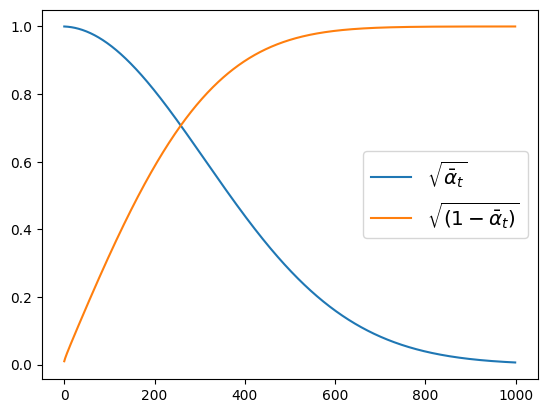

In [35]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
plt.plot(
    noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$"
)
plt.plot(
    (1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5,
    label=r"$\sqrt{(1 - \bar{\alpha}_t)}$",
)
plt.legend(fontsize="x-large")

## Задание 11 (0.5 балла)

Реализуйте нейронную сеть. В качетсве архитектуры можете взять модель генератора. В процессе экспериментов попробуйте изменять архитектуру модели для улучшения качества сгенерированных объектов (Кстати, как вы будете качество измерять?).

- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

Качество можно наверно посмотреть по ROC-AUC, где он ближе к 0.5, там получше моделька работает

In [36]:
class DiffusionGenerator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(DiffusionGenerator, self).__init__()

        ### YOUR CODE IS HERE ######
        self.fc1 = nn.Linear(n_inputs, 100) #Полносвязный слой со 100 нейронами
        self.bn1 = nn.BatchNorm1d(100) # Слой батч-нормализации
        self.relu1 = nn.ReLU() # ReLU функцию активации
        self.fc2 = nn.Linear(100, 100) # Полносвязный слой со 100 нейронами
        self.bn2 = nn.BatchNorm1d(100) # Слой батч-нормализации
        self.relu2 = nn.ReLU() # ReLU функцию активации
        self.fc3 = nn.Linear(100, n_outputs) # Выходной слой
        ### THE END OF YOUR CODE ###

    def forward(self, z, y):
        zy = torch.cat((z, y), dim=1)
        output = self.fc1(zy) #Применяем все слои и функции
        output = self.bn1(output)
        output = self.relu(output)
        output = self.fc2(output)
        output = self.bn2(output)
        output = self.relu2(output)
        output = self.fc3(output)
        return output

## Задание 12 (0.5 балла)

Напишите функцию для генерации нового объекта с помощью обученной модели.

In [37]:
def generate_with_diffusion(model, y, latent_dim, sheduler):
    ### YOUR CODE IS HERE ######
    timesteps = torch.linspace(0, 999, 9510).long() #Это подобрано методом проб и ошибок
    y = torch.tensor(y).float()
    noise = torch.randn((y.shape[0], latent_dim))
    noisy_xb = noise_scheduler.add_noise(y, noise, timesteps) #Шум с шедулером
    with torch.no_grad():
      X_fake = model(noisy_xb.cuda(), y.cuda()) #Испольщуем модель для генерации объектов
    ### THE END OF YOUR CODE ###
    return X_fake.detach().cpu().numpy()  # numpy

## Задание 13 (2 балла)

Напишите класс обучения диффузионной модели и обучите модель, после чего опишите полученные результаты. В качестве подсказки - опирайтесь на семинар по диффузионным моделям. Вы можете изменять некоторые части кода для вашего удобства, но оставляйте в таком случаи комментарии, пожалуйста.

In [38]:
class DiffusionFitter(object):
    def __init__(
        self,
        model,
        batch_size=32,
        n_epochs=10,
        latent_dim=1,
        lr=0.0001,
        n_critic=5,
    ):

        self.model = generator
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.opt_gen = torch.optim.RMSprop(self.model.parameters(), lr=self.lr)
        self.loss_fn = nn.MSELoss() #Добавляем лосс, МСЕ взяла с семинара

        self.model.to(DEVICE)

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.model.train(True)

        self.loss_history = []

        # Fit GAN
        for epoch in range(self.n_epochs):
            loss_epoch = 0

            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):

                ### YOUR CODE IS HERE ######
                noise_amount = torch.rand(real_batch.shape[0]) #кол-во шума
                noisy_x = corrupt(real_batch, noise_amount) #Шум
                pred = self.model(noisy_x, cond_batch)  # Генерация с помощью модели
                loss = self.loss_fn(pred, real_batch) #Считаем лосс
                self.opt_gen.zero_grad() #Обнуление градиентов
                loss.backward()
                self.opt_gen.step() #Шаг оптимизатора
                loss_epoch += loss.item() #Прибаляем лосс
            loss_epoch = loss_epoch / (i + 1) #Средний лосс по эпохе - суммарный лосс, деленный на количество итераций, i+1, тк нумерация с 0 начинается
                ### THE END OF YOUR CODE ###

            # caiculate and store loss after an epoch

            self.loss_history.append(loss_epoch)

            # Создайте выборку из 1000 объектов из X_train и 1000 сгенерированных объектов
            # И запустите работу фукнции other_agent_score

            ### YOUR CODE IS HERE ######
            real_ob = X_real[:1000].to(DEVICE) #Реальные объекты
            noise_amount = torch.rand(real_ob.shape[0]) #кол-во шума
            noisy_x = corrupt(real_ob, noise_amount) #Шум
            fake_ob = self.model(noisy_x, y_cond[:1000])#Фейковые сгенерированные объекты
            other_agent_score(real_ob.cpu().detach().numpy(), torch.ones(1000), fake_ob.cpu().detach().numpy(), torch.zeros(1000)) #Запускаем функцию
            ### THE END OF YOUR CODE ###

        # Turn off training
        self.model.train(False)

In [39]:
%%time
latent_dim = 10
model = DiffusionGenerator(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1])

diffusionFitter = DiffusionFitter(
    model,
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
diffusionFitter.fit(X_train, y_train)

Linear regression score: 0.554
Boosting score: 0.726
Linear regression score: 0.454
Boosting score: 0.712
Linear regression score: 0.49
Boosting score: 0.672
Linear regression score: 0.45
Boosting score: 0.638
Linear regression score: 0.476
Boosting score: 0.622
Linear regression score: 0.478
Boosting score: 0.636
Linear regression score: 0.458
Boosting score: 0.606
Linear regression score: 0.488
Boosting score: 0.618
Linear regression score: 0.522
Boosting score: 0.612
Linear regression score: 0.498
Boosting score: 0.616
Linear regression score: 0.484
Boosting score: 0.61
Linear regression score: 0.466
Boosting score: 0.6
Linear regression score: 0.478
Boosting score: 0.602
Linear regression score: 0.47
Boosting score: 0.634
Linear regression score: 0.446
Boosting score: 0.606
Linear regression score: 0.504
Boosting score: 0.572
Linear regression score: 0.512
Boosting score: 0.63
Linear regression score: 0.496
Boosting score: 0.596
Linear regression score: 0.476
Boosting score: 0.616


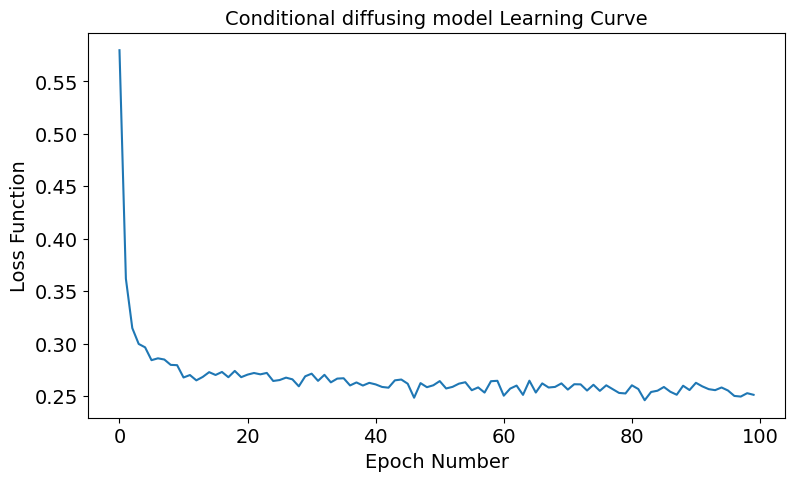

In [40]:
# diffusion learning curve
plt.figure(figsize=(9, 5))
plt.plot(diffusionFitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional diffusing model Learning Curve", size=14)
# plt.grid(b=1, linestyle="--", linewidth=0.5, color="0.5") - эта штука не работает, убрала ее
plt.show()

Видим, что здесь лосс побольше итоговый, в отличие от Gan модели. Диффузионная модель работает похуже в этом плане

Попробуем поменять архитектуру, посмотрим, что получится

In [41]:
class DiffusionGenerator_version2(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(DiffusionGenerator_version2, self).__init__()

        ### YOUR CODE IS HERE ######
        self.fc1 = nn.Linear(n_inputs, 150) #Полносвязный слой со 100 нейронами
        self.bn1 = nn.BatchNorm1d(150) # Слой батч-нормализации
        self.relu1 = nn.ReLU() # ReLU функцию активации
        self.fc2 = nn.Linear(150, 100) # Полносвязный слой со 100 нейронами
        self.bn2 = nn.BatchNorm1d(100) # Слой батч-нормализации
        self.relu2 = nn.ReLU() # ReLU функцию активации
        self.fc3 = nn.Linear(100, 50) # Выходной слой
        self.bn3 = nn.BatchNorm1d(50) # Слой батч-нормализации
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(50, n_outputs)

        ### THE END OF YOUR CODE ###

    def forward(self, z, y):
        zy = torch.cat((z, y), dim=1)
        output = self.fc1(zy) #Применяем все слои и функции
        output = self.bn1(output)
        output = self.relu(output)
        output = self.fc2(output)
        output = self.bn2(output)
        output = self.relu2(output)
        output = self.fc3(output)
        output = self.bn3(output)
        output = self.relu3(output)
        output = self.fc4(output)

        return output

In [42]:
%%time
latent_dim = 10
model_2 = DiffusionGenerator_version2(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1])

diffusionFitter_2 = DiffusionFitter(
    model_2,
    batch_size=70,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.01,
    n_critic=5,
)
diffusionFitter_2.fit(X_train, y_train)

Linear regression score: 0.604
Boosting score: 0.672
Linear regression score: 0.628
Boosting score: 0.638
Linear regression score: 0.574
Boosting score: 0.636
Linear regression score: 0.54
Boosting score: 0.618
Linear regression score: 0.556
Boosting score: 0.648
Linear regression score: 0.584
Boosting score: 0.638
Linear regression score: 0.554
Boosting score: 0.642
Linear regression score: 0.558
Boosting score: 0.622
Linear regression score: 0.6
Boosting score: 0.654
Linear regression score: 0.562
Boosting score: 0.62
Linear regression score: 0.554
Boosting score: 0.614
Linear regression score: 0.522
Boosting score: 0.646
Linear regression score: 0.494
Boosting score: 0.642
Linear regression score: 0.552
Boosting score: 0.672
Linear regression score: 0.57
Boosting score: 0.656
Linear regression score: 0.57
Boosting score: 0.592
Linear regression score: 0.526
Boosting score: 0.588
Linear regression score: 0.538
Boosting score: 0.608
Linear regression score: 0.57
Boosting score: 0.72
L

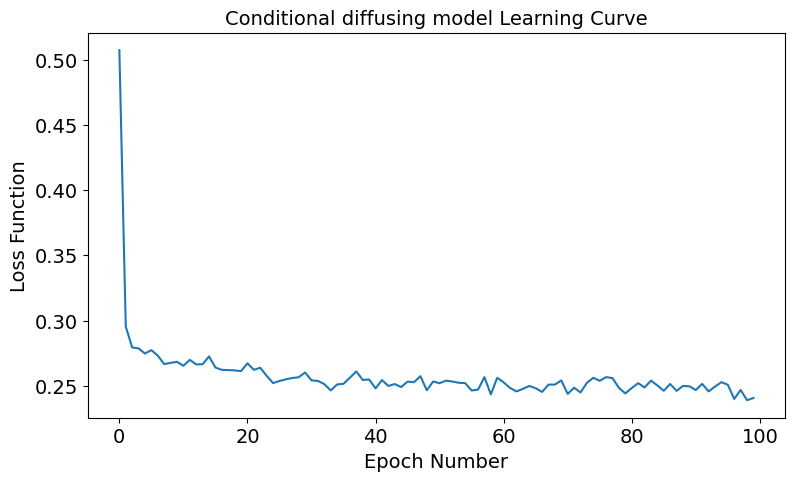

In [43]:
# diffusion learning curve
plt.figure(figsize=(9, 5))
plt.plot(diffusionFitter_2.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional diffusing model Learning Curve", size=14)
# plt.grid(b=1, linestyle="--", linewidth=0.5, color="0.5") - эта штука не работает, убрала ее
plt.show()

Видим, что ничего почти не поменялось, по крайней мере лосс ниже не опустился

## Задание 14 (0.5 балла)
По аналогии с прошлым экспериментом с GAN моделью сгенерируйте выборку фейковых объектов равную размеру тестовой выборки и обучите градиентный бустинг. Обучите модель отличать реальные объекты от фейковых, после чего расчитайте метрики ROC-AUC и accuracy score. Какие получились результаты? Как вы их оцениваете? А в сравнении с GAN моделью?

In [44]:
X_fake_train = generate_with_diffusion(diffusionFitter.model, y_train, latent_dim, noise_scheduler) #Создаем фейковые объекты
X_fake_test = generate_with_diffusion(diffusionFitter.model, y_test, latent_dim, noise_scheduler)

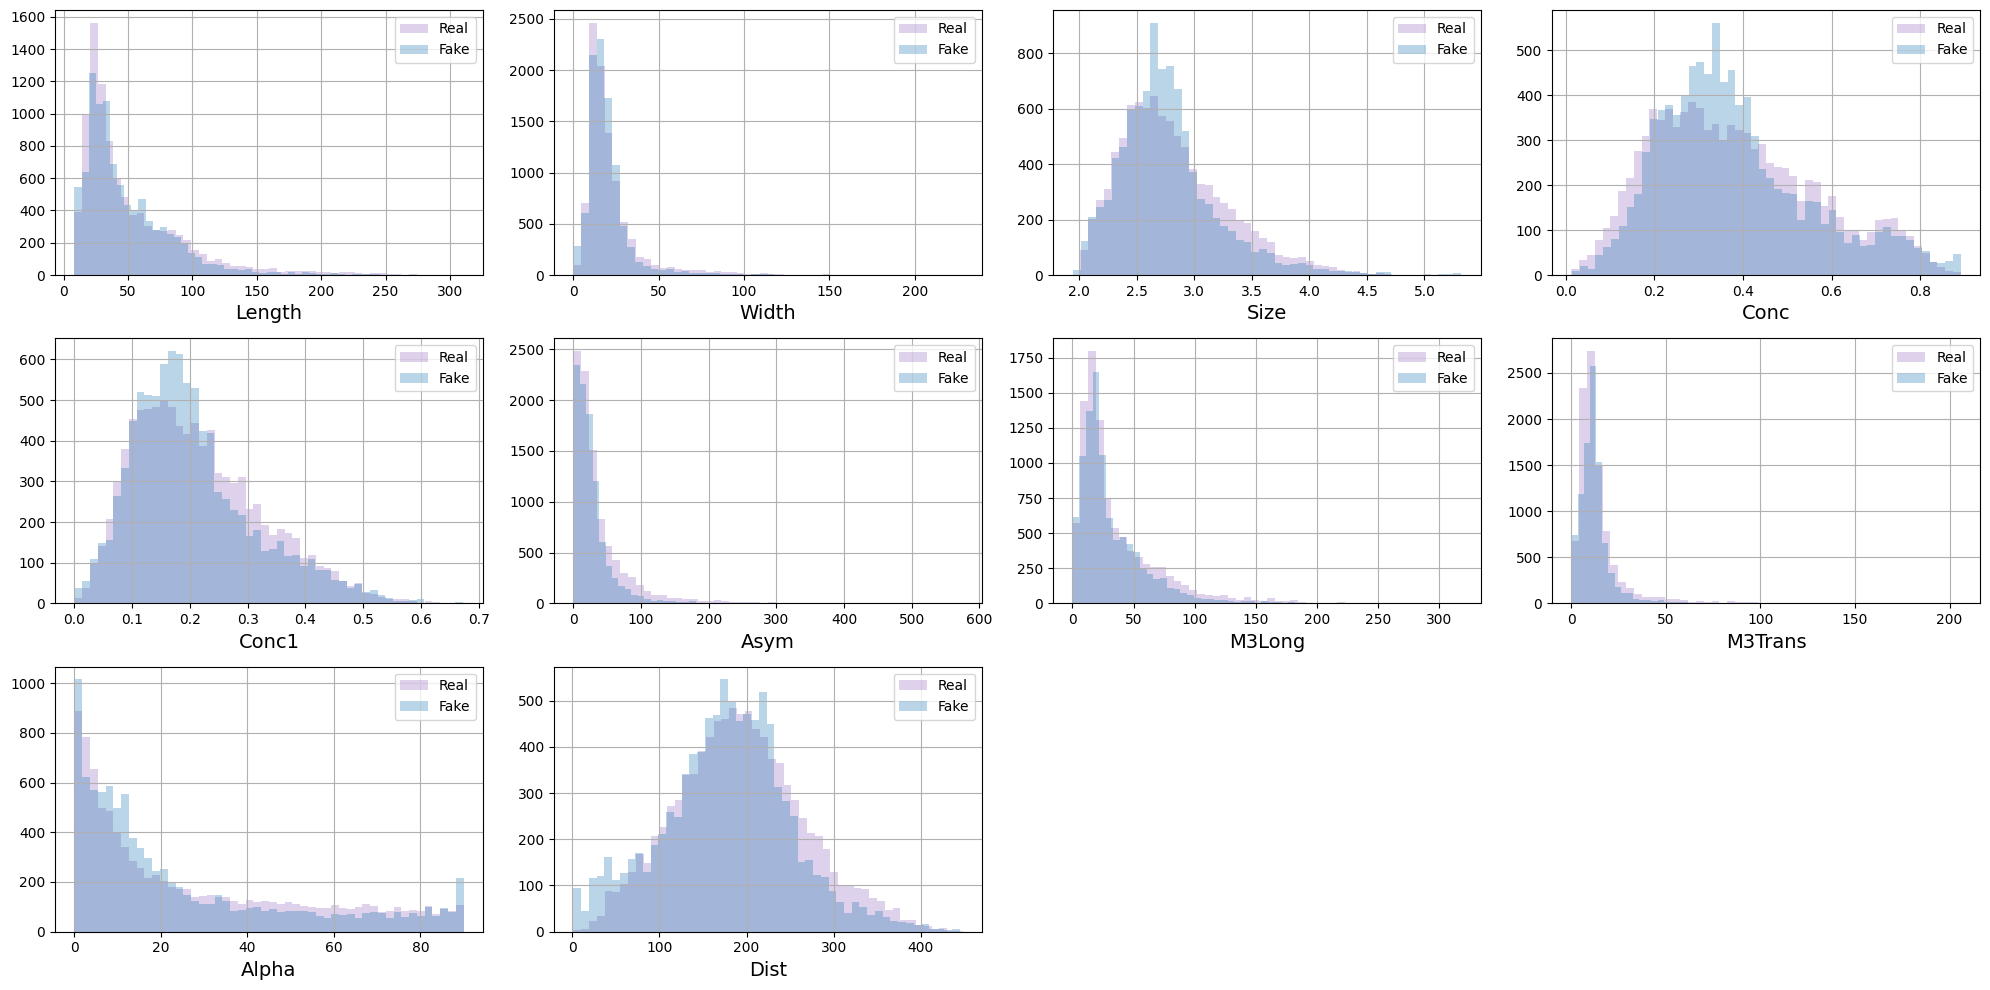

In [45]:
X_fake_train_tr = transformer.inverse_transform(X_fake_train) #Обратное преобразование
X_train_tr = transformer.inverse_transform(X_train)
plot_hists(X_train_tr, X_fake_train_tr, names, label1="Real", label2="Fake", bins=50)

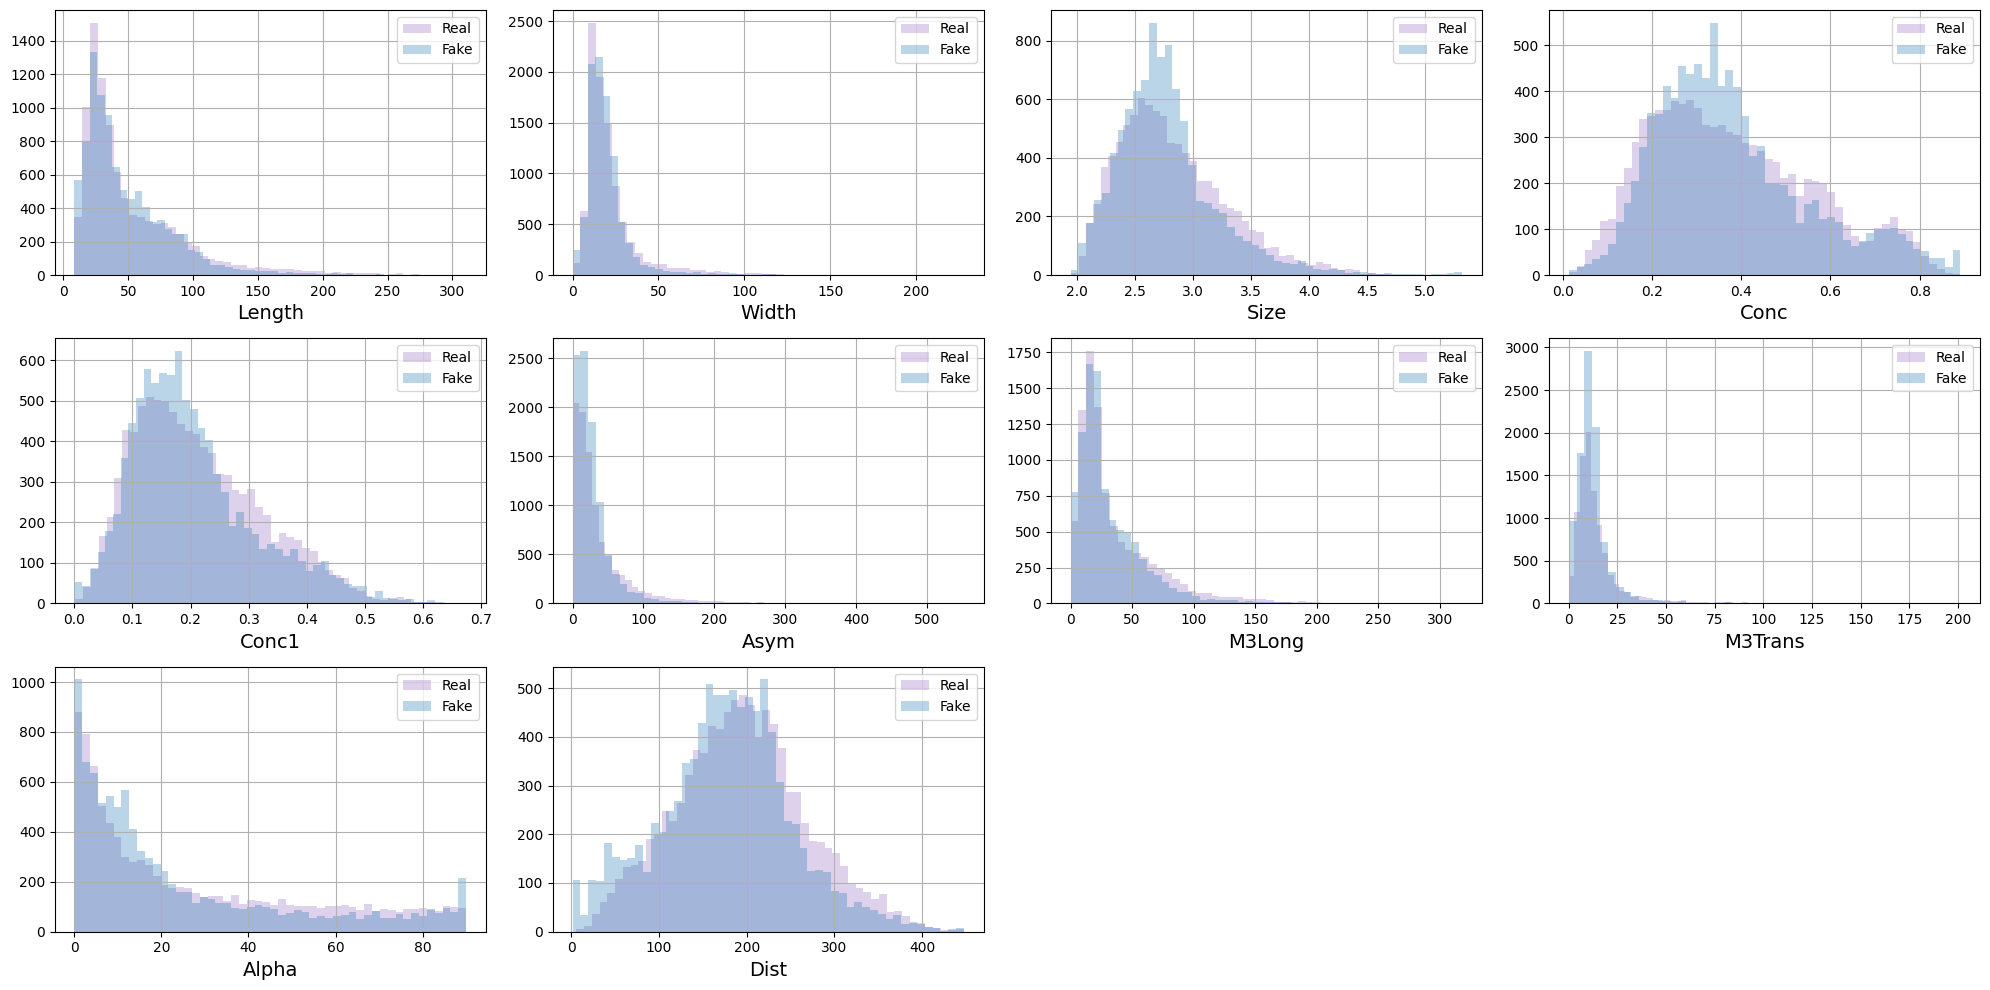

In [46]:
X_fake_test_tr = transformer.inverse_transform(X_fake_test) #Обратное преобразование
X_test_tr=transformer.inverse_transform(X_test)
plot_hists(X_test_tr, X_fake_test_tr, names, label1="Real", label2="Fake", bins=50)

In [47]:
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train, X_train), axis=0)
XX_test = np.concatenate((X_fake_test, X_test), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test))

In [48]:
from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [49]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.8855924805478985


In [50]:
#То же самое для второй модели
X_fake_train = generate_with_diffusion(diffusionFitter_2.model, y_train, latent_dim, noise_scheduler) #Создаем фейковые объекты
X_fake_test = generate_with_diffusion(diffusionFitter_2.model, y_test, latent_dim, noise_scheduler)
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train, X_train), axis=0)
XX_test = np.concatenate((X_fake_test, X_test), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test))
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]
auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.8803716658871452


Получился достаточно высокий ROC-AUC. Это значит, что наша модель достаточно хорошо отличает фейковые объекты от реальных. Для нас это плохо, ведь мы хотим, чтобы фейковые объекты были неотличимы от реальных, те чтобы ROC-AUC был около 0.5. В сравнении с GAN моделью можно сказать, что GAN работает лучше для нашей задачи, ведь у нее ROC-AUC меньше. То есть модель хуже отличает реальные объекты от сгенерированных, а значит фейки очень похожи на настоящие объекты

## Отзыв

Поздравляю! Вы дошли до конца. Оставьте ваш отзыв ячейкой ниже или отправьте его в канал курса, нам будет очень интересно!

In [51]:
# Хорошего дня\вечера\ночи проверяющему ! :)